In [6]:
%run ../ts_boilerplate/dataprep_2.py

Model is not converging.  Current: 9681.824198435965 is not greater than 9681.93517116418. Delta is -0.11097272821461956


Markdown feature documentation written to: ../docs/feature_documentation.md
(2891, 35)


In [7]:
final_df.head()

,PPH_Open,PPH_High,PPH_Low,PPH_Close,PPH_Volume,XPH_Open,XPH_High,XPH_Low,XPH_Close,XPH_Volume,...,XPH_Ratio_PPH_t-1,day_of_week,day_of_month,month,quarter,is_holiday_adjacent,days_to_cpi,days_since_cpi,days_to_nfp,days_since_nfp
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-04,53.450001,53.700001,53.369999,53.680000,117000,44.595001,44.820000,44.215000,44.490002,180200,...,0.833804,1,4,2,1,0,9,24,32,2
2014-02-05,53.799999,53.959999,53.450001,53.840000,40400,44.430000,44.509998,43.535000,44.299999,184400,...,0.828800,2,5,2,1,0,8,25,31,3
2014-02-06,53.959999,54.090000,53.790001,53.959999,24200,44.610001,44.775002,43.970001,44.195000,76800,...,0.822808,3,6,2,1,0,7,26,30,4
2014-02-07,54.200001,54.959999,54.139999,54.959999,36100,44.419998,45.349998,44.244999,45.349998,186800,...,0.819033,4,7,2,1,0,6,27,29,5
2014-02-10,55.029999,55.349998,54.900002,55.349998,173000,45.424999,45.959999,45.185001,45.959999,127200,...,0.825146,0,10,2,1,0,3,30,26,8


In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from pathlib import Path
import sys

In [17]:
# Ensure project root is in sys.path
project_root = Path.cwd().parent  # parent of "notebooks"
sys.path.insert(0, str(project_root))

print("Project root:", project_root)
print("ts_boilerplate exists:", (project_root / "ts_boilerplate").exists())

from ts_boilerplate.dataprep_2 import build_feature_dataset

df_final = build_feature_dataset()
print(df_final.shape)
df_final.head()

Model is not converging.  Current: 9691.782719498273 is not greater than 9691.841019095262. Delta is -0.05829959698894527


Project root: /Users/arnaudthomas/code/bennystu/Trend-Surgeon/Trend-Surgeon-Time-Series
ts_boilerplate exists: True
Markdown feature documentation written to: ../docs/feature_documentation.md
(2891, 35)


,PPH_Open,PPH_High,PPH_Low,PPH_Close,PPH_Volume,XPH_Open,XPH_High,XPH_Low,XPH_Close,XPH_Volume,...,XPH_Ratio_PPH_t-1,day_of_week,day_of_month,month,quarter,is_holiday_adjacent,days_to_cpi,days_since_cpi,days_to_nfp,days_since_nfp
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-04,53.450001,53.700001,53.369999,53.680000,117000,44.595001,44.820000,44.215000,44.490002,180200,...,0.833804,1,4,2,1,0,9,24,32,2
2014-02-05,53.799999,53.959999,53.450001,53.840000,40400,44.430000,44.509998,43.535000,44.299999,184400,...,0.828800,2,5,2,1,0,8,25,31,3
2014-02-06,53.959999,54.090000,53.790001,53.959999,24200,44.610001,44.775002,43.970001,44.195000,76800,...,0.822808,3,6,2,1,0,7,26,30,4
2014-02-07,54.200001,54.959999,54.139999,54.959999,36100,44.419998,45.349998,44.244999,45.349998,186800,...,0.819033,4,7,2,1,0,6,27,29,5
2014-02-10,55.029999,55.349998,54.900002,55.349998,173000,45.424999,45.959999,45.185001,45.959999,127200,...,0.825146,0,10,2,1,0,3,30,26,8


In [18]:
H = 30  # même horizon que dans dataprep2

df_final["target_future"] = df_final["target_close"].shift(-H)
df_final = df_final.dropna(subset=["target_future"])

In [20]:
y = df_final["target_future"]
X = df_final.drop(columns=["target_future"])

In [21]:
split_idx = int(len(df_final) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [23]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    tree_method="hist"
)

model.fit(X_train_scaled, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [24]:
y_pred = model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE :", rmse)
print("MAE  :", mae)

RMSE : 12.047927325160314
MAE  : 10.347878807294222


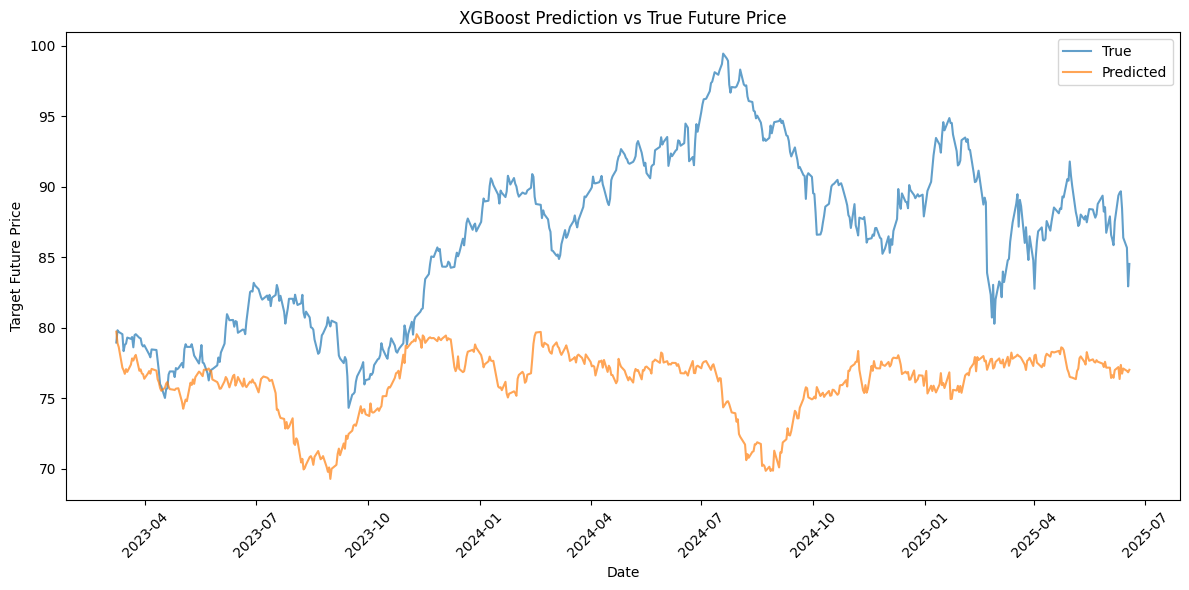

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Important : utiliser l'index de y_test comme axe X
plt.plot(y_test.index, y_test.values, label="True", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted", alpha=0.7)

plt.legend()
plt.title("XGBoost Prediction vs True Future Price")
plt.xlabel("Date")
plt.ylabel("Target Future Price")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
last_row = X.iloc[-1:]
last_row_scaled = scaler.transform(last_row)

future_pred = model.predict(last_row_scaled)[0]
future_pred

np.float32(77.0155)

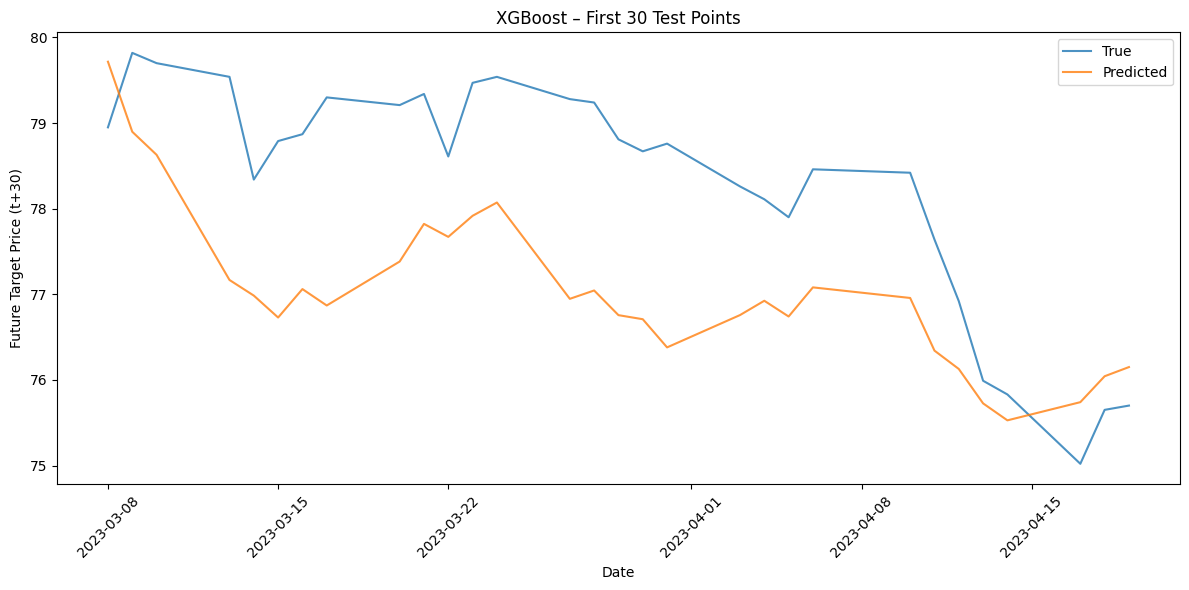

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir les prédictions en Series avec index temporel
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Sélection des 30 premiers points
n = 30
y_test_first = y_test.iloc[:n]
y_pred_first = y_pred_series.iloc[:n]

plt.figure(figsize=(12,6))
plt.plot(y_test_first.index, y_test_first.values, label="True", alpha=0.8)
plt.plot(y_pred_first.index, y_pred_first.values, label="Predicted", alpha=0.8)

plt.title("XGBoost – First 30 Test Points")
plt.xlabel("Date")
plt.ylabel("Future Target Price (t+30)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()